In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, 
    f1_score, roc_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from pygam import s, te, f, LogisticGAM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ortho_group

import xgboost as xgb

from src.data_generation import *
from src.analysis import ModelEvaluator
from src.utils import *
from src.plotting import visualize_feature_shifts

from src.robust_training.mechanistic import MechanisticTrainer
from src.robust_training.mechanistic import run_mechanistic_robust_training_and_eval_in_memory

np.random.seed(0)

GRID_SEARCH = False
PLOT = False
GEN_DATA = True



ImportError: cannot import name 'run_mechanistic_robust_training_and_eval_in_memory' from 'src.robust_training.mechanistic' (c:\Users\giaco\Documenti\statistical_methods\final_proj\distribution-shift\src\robust_training\mechanistic.py)

In [5]:
from typing import Dict


def evaluate_model(model, df_dict: Dict[float, pd.DataFrame], target: str) -> float:
    """Calculate mean AUC across all shift levels"""
    aucs = []
    for _, df in df_dict.items():
        X_test = df.drop(columns=[target])
        y_test = df[target]
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
            aucs.append(auc)
        except:
            continue
    return np.mean(aucs)

def evaluate_model_final(model, final_test_df: pd.DataFrame, target: str) -> float:
    """Calculate AUC specifically on the final test set (mix=1.0)"""
    X_test = final_test_df.drop(columns=[target])
    y_test = final_test_df[target]
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        return roc_auc_score(y_test, y_proba)
    except:
        return 0.0

def grid_search_parameters(
    df_train: pd.DataFrame,
    df_dict: Dict[float, pd.DataFrame],
    target: str = 'Y',
    shift_factors: list = [0.001, 0.01, 0.1],
    fractions: list = [0.3, 0.5, 0.7, 0.9],
    model_types: list = ['tree', 'gbc', 'rfc'],
    random_state: int = 42,
    **kwargs
) -> Dict:
    results = []
    final_test_df = df_dict[1.0]  # Get the test set with mix=1.0
    
    for model_type in model_types:
        for shift_factor in shift_factors:
            for fraction in fractions:
                print(f"\nTesting shift_factor={shift_factor}, fraction={fraction}, model_type={model_type}")
                
                baseline_model, robust_model = run_mechanistic_robust_training_and_eval_in_memory(
                    df_train=df_train,
                    df_dict=df_dict,
                    target=target,
                    base_shift_factor=shift_factor,
                    fraction_to_shift=fraction,
                    model_type=model_type,
                    random_state=random_state,
                    **kwargs
                )
                
                # Calculate both overall and final test performance
                overall_robust_score = evaluate_model(robust_model, df_dict, target)
                overall_baseline_score = evaluate_model(baseline_model, df_dict, target)
                final_robust_auc = evaluate_model_final(robust_model, final_test_df, target)
                final_baseline_auc = evaluate_model_final(baseline_model, final_test_df, target)
                
                results.append({
                    'model_type': model_type,
                    'shift_factor': shift_factor,
                    'fraction': fraction,
                    'overall_robust_score': overall_robust_score,
                    'overall_baseline_score': overall_baseline_score,
                    'final_robust_auc': final_robust_auc,
                    'final_baseline_auc': final_baseline_auc,
                    'overall_improvement': overall_robust_score - overall_baseline_score,
                    'final_improvement': final_robust_auc - final_baseline_auc
                })
    
    results_df = pd.DataFrame(results)
    
    # Find best performance per model
    best_per_model = {}
    for mt in model_types:
        model_subset = results_df[results_df['model_type'] == mt]
        if not model_subset.empty:
            # Best by overall score
            best_overall_idx = model_subset['overall_robust_score'].idxmax()
            best_overall = model_subset.loc[best_overall_idx]
            
            # Best by final test performance
            best_final_idx = model_subset['final_robust_auc'].idxmax()
            best_final = model_subset.loc[best_final_idx]
            
            best_per_model[mt] = {
                'overall_best': {
                    'robust_score': best_overall['overall_robust_score'],
                    'baseline_score': best_overall['overall_baseline_score'],
                    'params': {
                        'model_type': mt,
                        'shift_factor': best_overall['shift_factor'],
                        'fraction': best_overall['fraction']
                    }
                },
                'final_best': {
                    'robust_auc': best_final['final_robust_auc'],
                    'baseline_auc': best_final['final_baseline_auc'],
                    'params': {
                        'model_type': mt,
                        'shift_factor': best_final['shift_factor'],
                        'fraction': best_final['fraction']
                    }
                }
            }
        else:
            best_per_model[mt] = None
            
    return {
        'results_df': results_df,
        'best_per_model': best_per_model
    }



In [6]:
N = 50  # Number of times to generate data and run the grid search

# We'll store the best results for each iteration in a list of dicts:
all_best_per_model = []

# Data generation parameters
num_samples = 10000
num_features = 3
degree = 2  # degree for polynomial
all_covariance_shifts = [] 

# ------------------------------------------------------------
# Generate TRAIN data once (outside the loop)
# ------------------------------------------------------------
if GEN_DATA:
    mean_train = [0.90920214, 0.81962487, 0.88819135]
    covariance_train = np.array([
        [0.726318,     0.20240102,  0.52472545],
        [0.20240102,   0.11392557,  0.0264108],
        [0.52472545,   0.0264108,   1.05107627]
    ])
    
    sample_train = build_multivariate_sample(num_samples, mean_train, covariance_train)
    df_train = pd.DataFrame(sample_train, columns=[f'X{i+1}' for i in range(num_features)])
    
    # Polinomial coefficients for target generation
    coef = [
        -0.8061577012389105, -0.3621987584904036, -0.16057091147074054, 
         0.4803476403769713, -0.10624889645240687,  0.3182084398201366, 
         0.6789895126695962, -0.791324832566177,    0.531479159887424, 
         0.49115959567000167
    ]
    y_train,  coef_train = build_poly_target(sample_train, degree, coef)
    df_train['Y'] = y_train
    


# ------------------------------------------------------------
# Main loop - run N times
# ------------------------------------------------------------
for iteration in range(N):
    print(f"\n{'='*35}")
    print(f"   Iteration {iteration+1}/{N}")
    print(f"{'='*35}")
    
    # --------------------------------------------------------
    # Generate SHIFTED TEST data in each iteration (optional)
    # --------------------------------------------------------
    if GEN_DATA:
        mean_shift = attributes_quantile(df_train, 0.05)
        covariance_shift = random_cov(num_features, low=-0.5, high=0.5)
        all_covariance_shifts.append(covariance_shift)
        
        df_dict = {}
        for mix_prob in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 
                         0.6, 0.7, 0.8, 0.9, 1.0]:
            sample_mix = build_mixture_sample(
                num_samples, 
                mean_train, covariance_train, 
                mean_shift, covariance_shift, 
                mix_prob=mix_prob
            )
            df_mix = pd.DataFrame(sample_mix, columns=[f'X{i+1}' for i in range(num_features)])
            y_mix,  _ = build_poly_target(sample_mix, degree, coefficients=coef_train)
            df_mix['Y'] = y_mix
            
            df_dict[mix_prob] = df_mix

    # --------------------------------------------------------
    # Grid search: specify the models and parameters to test
    # --------------------------------------------------------
    grid_results = grid_search_parameters(
        df_train=df_train,
        df_dict=df_dict,
        target='Y',
        shift_factors=[0.005,0.008,0.01,0.02, 0.05], 
        fractions=[ 0.8,0.9,0.95,0.99],
        model_types=['gbc'],  
        n_rounds=1,
        random_state=42,
        noise_scale=0.0
    )
    
    # Extract the best result for each model
    best_per_model = grid_results['best_per_model']
    all_best_per_model.append(best_per_model)
    
    # Print a summary for this iteration
    for model_type, info in best_per_model.items():
        if info is not None:
            print(f"\n[Iteration {iteration+1}] Best for {model_type.upper()}:")
            print(f"  Score:       {info['overall_best']['robust_score']:.4f}")
            print(f"  Baseline:    {info['overall_best']['baseline_score']:.4f}")
            print(f"  shift_factor={info['overall_best']['params']['shift_factor']}, "
                f"fraction={info['overall_best']['params']['fraction']}")
        else:
            print(f"[Iteration {iteration+1}] No result found for model_type={model_type}.")


# ------------------------------------------------------------
# After finishing all iterations
# ------------------------------------------------------------
print("\nFinished all iterations.\n")
for i, best_dict in enumerate(all_best_per_model, start=1):
    print(f"========== Iteration {i} best results per model ===========")
    for model_type, info in best_dict.items():
        if info is not None:
            print(f"\n{model_type.upper()}:")
            print("  Overall Best:")
            print(f"    AUC: {info['overall_best']['robust_score']:.4f}")
            print(f"    Baseline: {info['overall_best']['baseline_score']:.4f}")
            print(f"    Params: {info['overall_best']['params']}")
            print("  Final Test Best:")
            print(f"    AUC: {info['final_best']['robust_auc']:.4f}")
            print(f"    Baseline: {info['final_best']['baseline_auc']:.4f}")
            print(f"    Params: {info['final_best']['params']}")
        else:
            print(f"  {model_type.upper()}: No result.")
    print("-----------------------------------------------------------")






   Iteration 1/50

Testing shift_factor=0.005, fraction=0.8, model_type=gbc
Training set shape = (10000, 3);  Target distribution:
Y
1    5495
0    4505
Name: count, dtype: int64

=== Training Baseline Model ===
=> Baseline model trained.

=== Training Robust Model ===
[MechanisticTrainer] Initial fit on full dataset.
[MechanisticTrainer] Augmentation Round 1/1
  => Augmenting 10000 samples.
  => Augmented pool size: 20000 samples
  => Downsampled combined data to 10000 total samples.
[MechanisticTrainer] Robust model training completed.

=> Robust model trained.

=== Evaluation on Shifted Datasets ===

Shift = 0.0
  Baseline => Accuracy: 0.780, F1: 0.794, AUC: 0.866
  Robust   => Accuracy: 0.783, F1: 0.797, AUC: 0.867
  Delta AUC (Robust - Baseline) = 0.0018

Shift = 0.1
  Baseline => Accuracy: 0.771, F1: 0.770, AUC: 0.857
  Robust   => Accuracy: 0.773, F1: 0.772, AUC: 0.855
  Delta AUC (Robust - Baseline) = -0.0012

Shift = 0.2
  Baseline => Accuracy: 0.769, F1: 0.758, AUC: 0.849
  

===== t-Test TEST RESULTS (GBC) =====
Mean AUC score Difference Across The 11 Test Sets:
  Mean diff (Robust - Baseline): 0.0083
  t-stat: 8.7501, p-value: 1.3943e-11
  95% CI: [0.0064, 0.0102]

 Mean AUC score Difference on the last Test Set:
  Mean diff (Robust - Baseline): 0.0235
  t-stat: 10.5940, p-value: 2.8644e-14
  95% CI: [0.0191, 0.0280]



C:\Users\andre\AppData\Local\Temp/ipykernel_28696/2478575465.py:1386: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


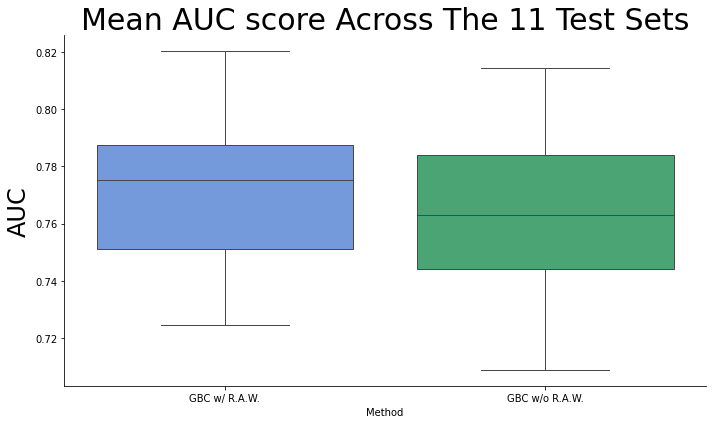

C:\Users\andre\AppData\Local\Temp/ipykernel_28696/2478575465.py:1401: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_gbc_final[df_gbc_final['Scenario']=='GBC Final'],


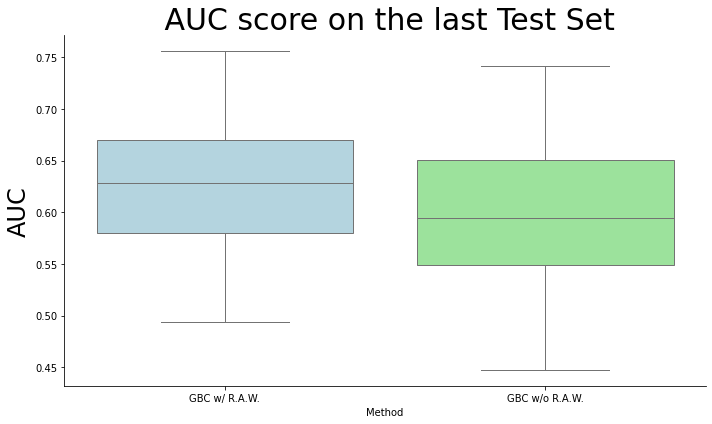

C:\Users\andre\AppData\Local\Temp/ipykernel_28696/2478575465.py:1413: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_diff[df_diff['Scenario']=='GBC Overall'], y='Difference', palette= 'viridis')


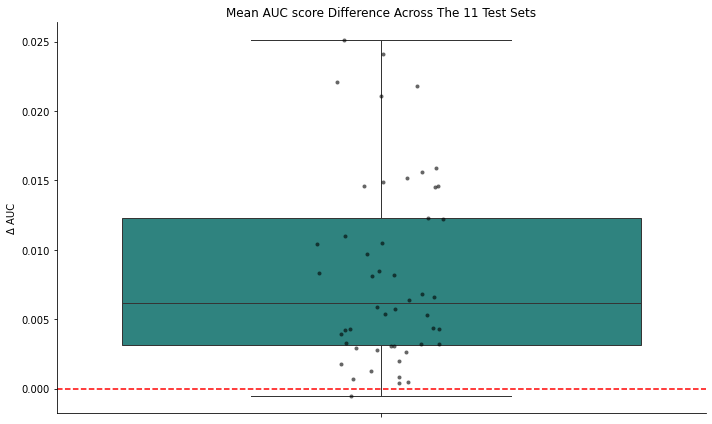

C:\Users\andre\AppData\Local\Temp/ipykernel_28696/2478575465.py:1425: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_diff[df_diff['Scenario']=='GBC Final'], y='Difference', palette= 'magma')


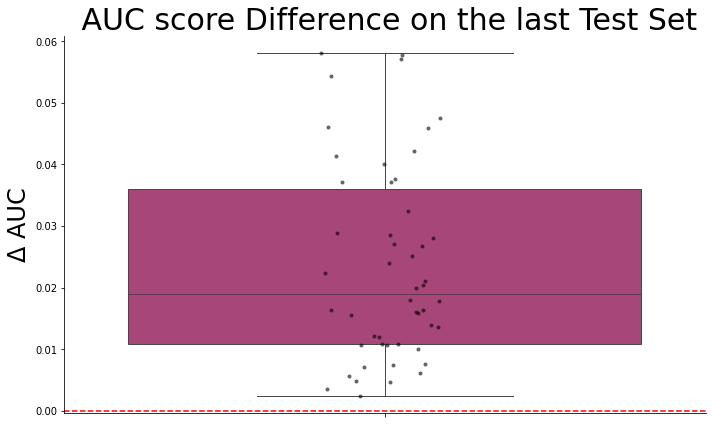

Script finished. Plots displayed and test results printed.


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import scipy.stats as st


"""
-------------------------------------------------------------
    Example script: Paired t-tests and Delta Method on AUC 
    scores comparing a robust approach vs. baseline under 
    covariate shift, plus exploratory visualizations.
-------------------------------------------------------------
"""

# ---------------------------------------------------------------------
# 1) Define the raw text data
# ---------------------------------------------------------------------
data_text = """========== Iteration 1 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7893
    Baseline: 0.7886
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6744
    Baseline: 0.6695
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 2 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7853
    Baseline: 0.7821
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6618
    Baseline: 0.6511
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 3 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7930
    Baseline: 0.7926
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.7024
    Baseline: 0.6950
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 4 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7511
    Baseline: 0.7468
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5828
    Baseline: 0.5668
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 5 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7826
    Baseline: 0.7795
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6396
    Baseline: 0.6232
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 6 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7909
    Baseline: 0.7877
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6824
    Baseline: 0.6763
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 7 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8073
    Baseline: 0.8068
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.7216
    Baseline: 0.7160
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 8 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7848
    Baseline: 0.7780
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6696
    Baseline: 0.6473
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 9 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7640
    Baseline: 0.7607
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6008
    Baseline: 0.5853
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 10 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7383
    Baseline: 0.7234
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.9}
  Final Test Best:
    AUC: 0.5300
    Baseline: 0.4886
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.9}
-----------------------------------------------------------
========== Iteration 11 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7372
    Baseline: 0.7290
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5300
    Baseline: 0.5033
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 12 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7536
    Baseline: 0.7439
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.5836
    Baseline: 0.5460
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 13 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7950
    Baseline: 0.7922
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6808
    Baseline: 0.6702
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 14 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7244
    Baseline: 0.7088
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.4935
    Baseline: 0.4474
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 15 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7987
    Baseline: 0.7956
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.7034
    Baseline: 0.6926
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 16 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7770
    Baseline: 0.7757
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6447
    Baseline: 0.6412
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 17 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8043
    Baseline: 0.8014
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.7270
    Baseline: 0.7161
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 18 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7767
    Baseline: 0.7684
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6540
    Baseline: 0.6288
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 19 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7588
    Baseline: 0.7442
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.9}
  Final Test Best:
    AUC: 0.5940
    Baseline: 0.5518
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 20 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7936
    Baseline: 0.7918
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6880
    Baseline: 0.6760
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 21 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7695
    Baseline: 0.7543
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6238
    Baseline: 0.5866
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 22 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7778
    Baseline: 0.7758
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6522
    Baseline: 0.6446
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 23 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7396
    Baseline: 0.7274
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5266
    Baseline: 0.4978
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 24 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7483
    Baseline: 0.7262
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5503
    Baseline: 0.5028
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 25 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7877
    Baseline: 0.7773
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6768
    Baseline: 0.6483
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 26 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7670
    Baseline: 0.7589
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6003
    Baseline: 0.5798
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 27 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7439
    Baseline: 0.7413
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5552
    Baseline: 0.5481
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 28 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7671
    Baseline: 0.7607
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6046
    Baseline: 0.5847
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 29 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7889
    Baseline: 0.7847
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6578
    Baseline: 0.6477
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 30 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7463
    Baseline: 0.7317
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.9}
  Final Test Best:
    AUC: 0.5606
    Baseline: 0.5235
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.9}
-----------------------------------------------------------
========== Iteration 31 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7808
    Baseline: 0.7590
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6472
    Baseline: 0.5929
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 32 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7408
    Baseline: 0.7355
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.5609
    Baseline: 0.5399
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 33 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7469
    Baseline: 0.7218
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5427
    Baseline: 0.4849
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 34 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7734
    Baseline: 0.7523
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6220
    Baseline: 0.5649
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 35 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7316
    Baseline: 0.7262
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5072
    Baseline: 0.4892
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 36 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7739
    Baseline: 0.7629
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6243
    Baseline: 0.5962
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 37 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7867
    Baseline: 0.7872
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6706
    Baseline: 0.6682
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 38 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7752
    Baseline: 0.7713
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6157
    Baseline: 0.6035
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 39 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7754
    Baseline: 0.7609
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6094
    Baseline: 0.5693
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 40 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7759
    Baseline: 0.7636
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6353
    Baseline: 0.6083
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 41 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7800
    Baseline: 0.7715
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6469
    Baseline: 0.6310
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 42 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7940
    Baseline: 0.7897
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6864
    Baseline: 0.6686
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 43 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7747
    Baseline: 0.7681
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6331
    Baseline: 0.6195
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 44 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8203
    Baseline: 0.8146
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.7557
    Baseline: 0.7417
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 45 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7453
    Baseline: 0.7409
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.5532
    Baseline: 0.5369
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 46 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7509
    Baseline: 0.7268
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.5580
    Baseline: 0.4999
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 47 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7792
    Baseline: 0.7633
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6363
    Baseline: 0.5904
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 48 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8093
    Baseline: 0.8085
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.7356
    Baseline: 0.7310
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 49 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7684
    Baseline: 0.7579
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6104
    Baseline: 0.5780
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 50 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7509
    Baseline: 0.7450
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5787
    Baseline: 0.5547
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
-----------------------------------------------------------
"""

data_text075 = """========== Iteration 1 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8140
    Baseline: 0.8139
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.7335
    Baseline: 0.7316
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 2 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8048
    Baseline: 0.7971
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6955
    Baseline: 0.6769
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 3 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8185
    Baseline: 0.8173
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.7639
    Baseline: 0.7589
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 4 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7632
    Baseline: 0.7557
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6127
    Baseline: 0.5887
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 5 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8004
    Baseline: 0.7908
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6723
    Baseline: 0.6455
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 6 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8152
    Baseline: 0.8110
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.7489
    Baseline: 0.7384
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 7 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8266
    Baseline: 0.8250
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.7679
    Baseline: 0.7589
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 8 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8108
    Baseline: 0.7989
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.7349
    Baseline: 0.7052
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 9 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7796
    Baseline: 0.7739
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6330
    Baseline: 0.6109
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 10 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7392
    Baseline: 0.7129
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5418
    Baseline: 0.4651
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 11 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7441
    Baseline: 0.7280
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.5432
    Baseline: 0.4974
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 12 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7545
    Baseline: 0.7412
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.5834
    Baseline: 0.5471
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 13 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8167
    Baseline: 0.8123
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.7340
    Baseline: 0.7220
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 14 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7238
    Baseline: 0.6946
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.4731
    Baseline: 0.3939
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 15 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8231
    Baseline: 0.8143
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.7637
    Baseline: 0.7376
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 16 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7997
    Baseline: 0.7953
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.7055
    Baseline: 0.6900
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 17 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8317
    Baseline: 0.8285
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.7901
    Baseline: 0.7796
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 18 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7932
    Baseline: 0.7794
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6970
    Baseline: 0.6644
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 19 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7724
    Baseline: 0.7456
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.9}
  Final Test Best:
    AUC: 0.6259
    Baseline: 0.5541
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 20 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8116
    Baseline: 0.8057
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.7223
    Baseline: 0.7010
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 21 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7729
    Baseline: 0.7484
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6412
    Baseline: 0.5820
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 22 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8035
    Baseline: 0.8023
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.7156
    Baseline: 0.7118
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 23 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7501
    Baseline: 0.7232
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5461
    Baseline: 0.4745
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 24 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7571
    Baseline: 0.7231
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5842
    Baseline: 0.4963
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 25 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8066
    Baseline: 0.7918
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.7265
    Baseline: 0.6853
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 26 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7768
    Baseline: 0.7635
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6255
    Baseline: 0.5904
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 27 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7513
    Baseline: 0.7478
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.5806
    Baseline: 0.5568
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 28 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7800
    Baseline: 0.7692
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6484
    Baseline: 0.6195
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 29 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8028
    Baseline: 0.7964
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6874
    Baseline: 0.6697
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 30 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7531
    Baseline: 0.7364
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.9}
  Final Test Best:
    AUC: 0.5805
    Baseline: 0.5394
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.9}
-----------------------------------------------------------
========== Iteration 31 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7875
    Baseline: 0.7646
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6727
    Baseline: 0.6192
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 32 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7502
    Baseline: 0.7400
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5722
    Baseline: 0.5432
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 33 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7489
    Baseline: 0.7096
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.5443
    Baseline: 0.4558
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 34 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7864
    Baseline: 0.7540
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6545
    Baseline: 0.5764
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 35 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7387
    Baseline: 0.7241
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.5079
    Baseline: 0.4782
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 36 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7941
    Baseline: 0.7771
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6841
    Baseline: 0.6371
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 37 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8079
    Baseline: 0.8064
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.7159
    Baseline: 0.7073
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 38 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7912
    Baseline: 0.7827
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6510
    Baseline: 0.6228
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 39 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7858
    Baseline: 0.7657
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6283
    Baseline: 0.5725
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 40 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7991
    Baseline: 0.7780
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6938
    Baseline: 0.6468
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 41 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8029
    Baseline: 0.7889
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.7030
    Baseline: 0.6754
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 42 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8128
    Baseline: 0.8074
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.7270
    Baseline: 0.7095
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 43 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7989
    Baseline: 0.7884
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.7050
    Baseline: 0.6799
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 44 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8384
    Baseline: 0.8240
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.8011
    Baseline: 0.7678
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 45 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7494
    Baseline: 0.7434
    Params: {'model_type': 'gbc', 'shift_factor': 0.01, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.5601
    Baseline: 0.5389
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 46 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7642
    Baseline: 0.7242
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.5791
    Baseline: 0.4822
    Params: {'model_type': 'gbc', 'shift_factor': 0.05, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 47 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7971
    Baseline: 0.7735
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.6732
    Baseline: 0.6090
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.95}
-----------------------------------------------------------
========== Iteration 48 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.8371
    Baseline: 0.8374
    Params: {'model_type': 'gbc', 'shift_factor': 0.008, 'fraction': 0.95}
  Final Test Best:
    AUC: 0.8026
    Baseline: 0.7992
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.99}
-----------------------------------------------------------
========== Iteration 49 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7813
    Baseline: 0.7673
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.8}
  Final Test Best:
    AUC: 0.6347
    Baseline: 0.5954
    Params: {'model_type': 'gbc', 'shift_factor': 0.005, 'fraction': 0.8}
-----------------------------------------------------------
========== Iteration 50 best results per model ===========

GBC:
  Overall Best:
    AUC: 0.7595
    Baseline: 0.7556
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
  Final Test Best:
    AUC: 0.6007
    Baseline: 0.5918
    Params: {'model_type': 'gbc', 'shift_factor': 0.02, 'fraction': 0.99}
-----------------------------------------------------------
"""



def parse_data(text):
    """
    Extract overall best and final test best AUC scores 
    for robust method and baseline, from text logs.
    Returns numpy arrays for arithmetic operations.
    """
    overall_robust_scores = []
    overall_baseline_scores = []
    final_robust_scores = []
    final_baseline_scores = []
    iterations = np.arange(1, 51)

    lines = text.splitlines()
    mode = None  # Can be "overall" or "final"

    for line in lines:
        line = line.strip()
        if line.startswith("Overall Best:"):
            mode = "overall"
        elif line.startswith("Final Test Best:"):
            mode = "final"
        elif line.startswith("AUC:"):
            # e.g. "AUC: 0.7893"
            auc_val = float(line.split(":")[1].strip())
            if mode == "overall":
                overall_robust_scores.append(auc_val)
            elif mode == "final":
                final_robust_scores.append(auc_val)
        elif line.startswith("Baseline:"):
            # e.g. "Baseline: 0.7886"
            baseline_val = float(line.split(":")[1].strip())
            if mode == "overall":
                overall_baseline_scores.append(baseline_val)
            elif mode == "final":
                final_baseline_scores.append(baseline_val)
                
                
    df = pd.DataFrame({
        'Iteration': iterations,
        'Overall_Robust': overall_robust_scores,
        'Overall_Baseline': overall_baseline_scores,
        'Final_Robust': final_robust_scores,
        'Final_Baseline': final_baseline_scores
    })

    
    df.to_csv('parsed_results05.csv', index=False)

    return (np.array(overall_robust_scores), np.array(overall_baseline_scores),
            np.array(final_robust_scores), np.array(final_baseline_scores))
            

(overall_robust_gbc,
 overall_baseline_gbc,
 final_robust_gbc,
 final_baseline_gbc) = parse_data(data_text)





###############################################################################

def t_test(robust_scores, baseline_scores, alpha=0.05):
    """
    Conducts a t test for whether the mean difference
    (robust - baseline) is 0.
    
    Returns: 
      mean_diff, t_stat, p_val, conf_interval (tuple)
    """
    diff = robust_scores - baseline_scores
    n = len(diff)
    mean_diff = np.mean(diff)
    var_diff = np.var(diff)   
    se_diff = np.sqrt(var_diff / n)   
    t_stat = mean_diff / se_diff
    
 
    p_val = 2.0 * (1.0 - st.t.cdf(abs(t_stat), df=n-1))
    
   
    ci_lower = mean_diff - st.t.ppf(1 - alpha/2, df=n-1) * se_diff
    ci_upper = mean_diff + st.t.ppf(1 - alpha/2, df=n-1) * se_diff
    
    return mean_diff, t_stat, p_val, (ci_lower, ci_upper)



# GBC: Overall
gbc_overall_mean_diff, gbc_overall_t, gbc_overall_p, gbc_overall_ci = \
    t_test(overall_robust_gbc, overall_baseline_gbc)

# GBC: Final Test
gbc_final_mean_diff, gbc_final_t, gbc_final_p, gbc_final_ci = \
    t_test(final_robust_gbc, final_baseline_gbc)



print("===== t-Test TEST RESULTS (GBC) =====")
print("Mean AUC score Difference Across The 11 Test Sets:")
print(f"  Mean diff (Robust - Baseline): {gbc_overall_mean_diff:.4f}")
print(f"  t-stat: {gbc_overall_t:.4f}, p-value: {gbc_overall_p:.4e}")
print(f"  95% CI: [{gbc_overall_ci[0]:.4f}, {gbc_overall_ci[1]:.4f}]\n")

print(" Mean AUC score Difference on the last Test Set:")
print(f"  Mean diff (Robust - Baseline): {gbc_final_mean_diff:.4f}")
print(f"  t-stat: {gbc_final_t:.4f}, p-value: {gbc_final_p:.4e}")
print(f"  95% CI: [{gbc_final_ci[0]:.4f}, {gbc_final_ci[1]:.4f}]\n")





df_gbc_overall = pd.DataFrame({
    'AUC': np.concatenate([overall_robust_gbc, overall_baseline_gbc]),
    'Method': ['Robust']*len(overall_robust_gbc) + ['Baseline']*len(overall_baseline_gbc),
    'Scenario': ['GBC Overall']*(2*len(overall_robust_gbc))
})

df_gbc_final = pd.DataFrame({
    'AUC': np.concatenate([final_robust_gbc, final_baseline_gbc]),
    'Method': ['Robust']*len(final_robust_gbc) + ['Baseline']*len(final_baseline_gbc),
    'Scenario': ['GBC Final']*(2*len(final_robust_gbc))
})

df_all = pd.concat([ df_gbc_overall, df_gbc_final],
                   ignore_index=True)

# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Scenario', y='AUC', hue='Method', data=df_all)
# sns.despine()
# plt.title("Boxplots of Mean AUC Scores : Robust vs. Baseline")
# plt.legend(loc='best')
# plt.tight_layout()
# plt.show()

diff_gbc_overall = overall_robust_gbc - overall_baseline_gbc
diff_gbc_final = final_robust_gbc - final_baseline_gbc

df_diff = pd.DataFrame({
    'Difference': np.concatenate([diff_gbc_overall, diff_gbc_final]),
    'Scenario': (
                 ['GBC Overall']*len(diff_gbc_overall) +
                 ['GBC Final']*len(diff_gbc_final))
})


# (C) Stripplot or swarmplot overlaid for better visualization of individual points
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Scenario', y='Difference', data=df_diff, showfliers=False)
# sns.stripplot(x='Scenario', y='Difference', data=df_diff, color='black', size=4, alpha=0.6)
# plt.axhline(0, color='red', linestyle='--')
# sns.despine()
# plt.title("Distribution of Differences (Robust - Baseline)")
# plt.tight_layout()
# plt.show()
# Plot 1: GBC Overall
plt.figure(figsize=(10, 6))
sns.boxplot(
  data=df_gbc_overall[df_gbc_overall['Scenario'] == 'GBC Overall'], 
  x='Method', 
  y='AUC',
  palette=['cornflowerblue', 'mediumseagreen']
)
plt.title("Mean AUC score Across The 11 Test Sets", fontsize=30)
plt.xticks([0, 1], ['GBC w/ R.A.W.', 'GBC w/o R.A.W.'])
plt.ylabel('AUC', fontsize=24)
sns.despine()
plt.tight_layout()
plt.show()

# Plot 2: GBC Final
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_gbc_final[df_gbc_final['Scenario']=='GBC Final'], 
            x='Method', y='AUC',
      palette=['lightblue', 'lightgreen'])
plt.title(" AUC score on the last Test Set", fontsize=30)
plt.xticks([0, 1], ['GBC w/ R.A.W.', 'GBC w/o R.A.W.'])
plt.ylabel('AUC', fontsize=24)
sns.despine() 
plt.tight_layout()
plt.show()

# Plot 3: GBC Overall Differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_diff[df_diff['Scenario']=='GBC Overall'], y='Difference', palette= 'viridis')
plt.ylabel('Δ AUC')
sns.stripplot(data=df_diff[df_diff['Scenario']=='GBC Overall'], 
             y='Difference', color='black', size=4, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Mean AUC score Difference Across The 11 Test Sets")
sns.despine()
plt.tight_layout()
plt.show()

# Plot 4: GBC Final Differences  
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_diff[df_diff['Scenario']=='GBC Final'], y='Difference', palette= 'magma')
sns.stripplot(data=df_diff[df_diff['Scenario']=='GBC Final'], 
             y='Difference', color='black', size=4, alpha=0.6)
plt.ylabel('Δ AUC', fontsize=24)

plt.axhline(0, color='red', linestyle='--')
plt.title(" AUC score Difference on the last Test Set", fontsize=30)
sns.despine()
plt.tight_layout()
plt.show()


print("Script finished. Plots displayed and test results printed.")
